In [55]:
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from datetime import timedelta
import Model as fxns
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [56]:
train = pd.read_csv('data/Train.csv')

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Size of data.

In [57]:
train.shape

(401125, 53)

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

## What does the data look like?

### Investigate Machine Hours

Theory: Machine Hours would be well correlated to the value of the equipment

In [5]:
machine_hours = train.MachineHoursCurrentMeter
print((machine_hours == 0).sum(), ' zero values')
print(machine_hours.isnull().sum(), ' missing values')

73126  zero values
258360  missing values


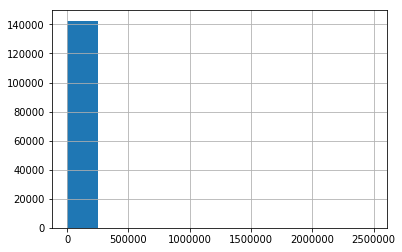

In [6]:
machine_hours.hist()

Histogram impacted by outliers.


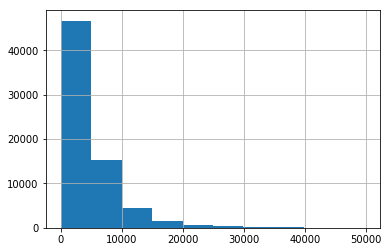

In [7]:
#histogram in range (0,50000)
machine_hours.loc[(machine_hours>0) & (machine_hours<50000)].hist()

In [8]:
len(machine_hours.loc[(machine_hours>0) & (machine_hours<50000)])

69120

Only 69120 data points

In [9]:
testdf = train.loc[(machine_hours>0) &
                  (machine_hours<50000)]

R-square: 0.17239458508438127
Len: 69120


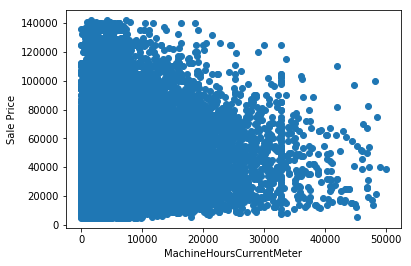

In [10]:
screen = fxns.Screening(testdf)
rsq = screen.analyze_Rsquare('MachineHoursCurrentMeter', plot=True, 
                       prints=True, continuous=True)

Even with this slice, Machine Hours only has a weak correlation of 
R^2 = 0.172. Looking at the graph, it looks like it does not correlate well with Sale Price and has a high percentage of points before x = 10000. Going to drop this columns for now.

## Drop All Columns that have NaNs

In [59]:
filtering = fxns.FilterColumns()
filtering.fit(train, train['SalePrice'])
train = filtering.transform(train)
train.shape

(401125, 13)

## Convert Categorical data to str, date to datetime

In [60]:
dtype = fxns.DataType()
dtype.fit(train, train['SalePrice'])
train = dtype.transform(train)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 13 columns):
SalesID               401125 non-null object
SalePrice             401125 non-null int64
MachineID             401125 non-null object
ModelID               401125 non-null object
datasource            401125 non-null int64
YearMade              401125 non-null int64
saledate              401125 non-null datetime64[ns]
fiModelDesc           401125 non-null object
fiBaseModel           401125 non-null object
fiProductClassDesc    401125 non-null object
state                 401125 non-null object
ProductGroup          401125 non-null object
ProductGroupDesc      401125 non-null object
dtypes: datetime64[ns](1), int64(3), object(9)
memory usage: 39.8+ MB


The DataFrame is now in a workable format, can start some more EDA and feature engineering 

# EDA

In [14]:
train.describe()

,SalePrice,datasource,YearMade
count,401125.000000,401125.000000,401125.000000
mean,31099.712848,134.665810,1899.156901
std,23036.898502,8.962237,291.797469
min,4750.000000,121.000000,1000.000000
25%,14500.000000,132.000000,1985.000000
50%,24000.000000,132.000000,1995.000000
75%,40000.000000,136.000000,2000.000000
max,142000.000000,172.000000,2013.000000


Issues:
datasource is an ID
YearMade has some outliers.

## Address YearMade outliers.

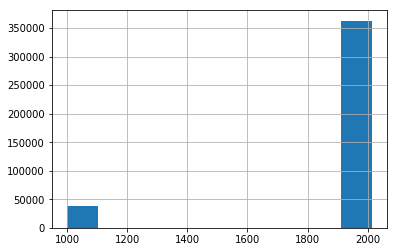

In [15]:
train.YearMade.hist()

Could potentially drop these 

In [16]:
(train.YearMade.value_counts() 
 / train.YearMade.count()).head()

1000    0.095195
1998    0.052904
2005    0.051323
2004    0.049910
1997    0.047130
Name: YearMade, dtype: float64

1000 makes up about 10% of the data. Instead of dropping, will replace with the mode

In [61]:
clean_year_made = fxns.ReplaceOutliers()
clean_year_made.fit(train, train['SalePrice'])
train = clean_year_made.transform(train)

In [18]:
(train.YearMade.value_counts() / train.YearMade.count()).head()

1998    0.148098
2005    0.051323
2004    0.049910
1997    0.047130
1999    0.046786
Name: YearMade, dtype: float64

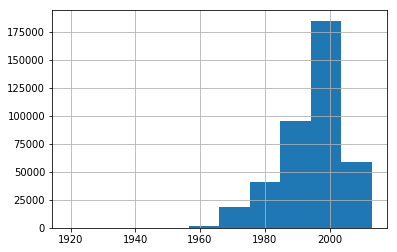

In [64]:
train.YearMade.hist()

# Sale Price EDA


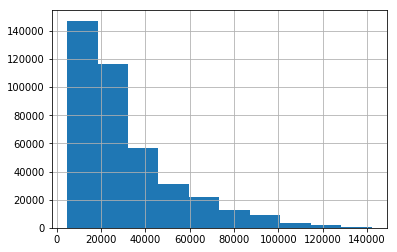

In [19]:
train.SalePrice.hist()

It looks like an exponential distribution.

Note: RMSLE error metric penalizes underpredictions.

# Feature Engineering: equipment_age

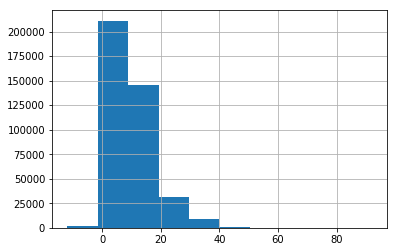

In [20]:
make_eq_age = fxns.ComputeAge()
make_eq_age.fit(train, train['SalePrice'])
train = make_eq_age.transform(train)
train.equipment_age.hist()

In [21]:
train.equipment_age.describe()

count    401125.000000
mean          9.934452
std           7.397564
min         -12.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          92.000000
Name: equipment_age, dtype: float64

In [22]:
age = train.equipment_age
(age<0).sum(), (age > 50).sum()

(2926, 196)

Note: Decent number of outliers below zero. May consider dropping later

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a422cf8>,
      dtype=object)

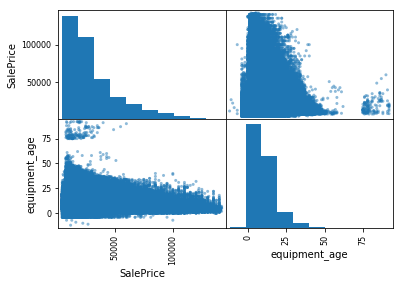

In [23]:
scatter_matrix(train[['SalePrice', 'equipment_age']])

Outliers at around 75 years old. 

# Feature Engineering: mean of 5 most recent sales per modelID

In [62]:
nearestmeans = fxns.ComputeNearestMean()
nearestmeans.fit(train, train['SalePrice'])
df = nearestmeans.transform(train)

In [25]:
df.filled_mean_price.describe()

count    401125.000000
mean      31099.692159
std       21016.725225
min        4950.000000
25%       15470.000000
50%       25600.000000
75%       39000.000000
max      140000.000000
Name: filled_mean_price, dtype: float64

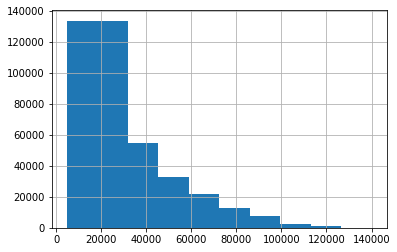

In [26]:
(df.filled_mean_price).hist()

The histogram of this near mean looks very similar to the saleprice. They could be well correlated

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a7c5192b0>,
      dtype=object)

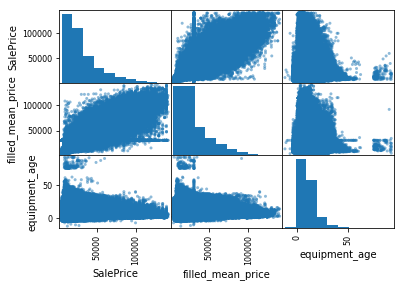

In [27]:
scatter_matrix(df[['SalePrice', 'filled_mean_price',
                           'equipment_age']])

In [51]:
df.head()

,YearMade,YearMade_imputed,equipment_age,filled_mean_price,no_recent_transactions
SalesID,,,,,
1139246,2004.0,0.0,2.0,54000.0,False
1139248,1996.0,0.0,8.0,50800.0,False
1139249,2001.0,0.0,3.0,17400.0,False
1139251,2001.0,0.0,10.0,19800.0,False
1139253,2007.0,0.0,2.0,13250.0,False


R-square: 0.8658654193631646
Len: 401125


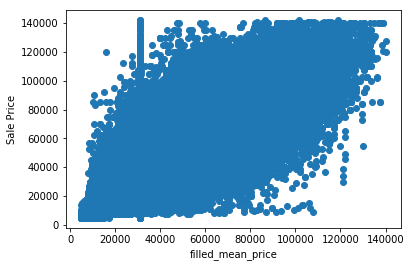

In [63]:
screen = fxns.Screening(df)
rsq = screen.analyze_Rsquare('filled_mean_price', plot=True, 
                       prints=True, continuous=True)

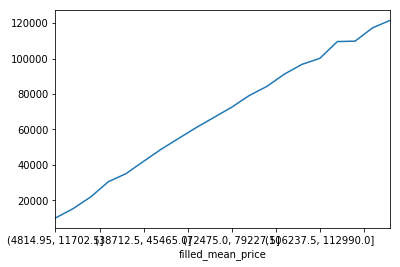

In [28]:
def percentile_plots(x, y):
    cuts = pd.cut(x, 20)
    y.groupby(cuts).mean().plot()
#filled_mean_price vs saleprice
percentile_plots(df.filled_mean_price, df.SalePrice)


So the mean price and sale price are very well correlated.

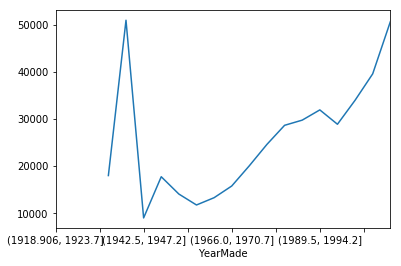

In [29]:
#year_made vs saleprice
percentile_plots(df.YearMade, df.SalePrice)

# Choose Cross Validation Set

Our goal is future transactions, So it is best to predict on a subset that is as late of a time as possible.

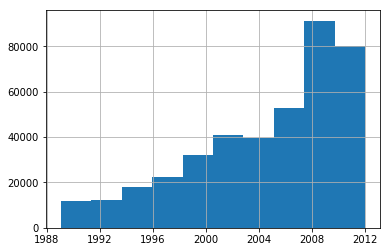

In [30]:
train.saledate.hist()

Ok, looks like we have more transactions recently, and we don't want to make our lives too hard by choosing a validation set that includes all of our most useful data.

In [31]:
train.saledate.quantile([.7, .8, .9, 1])

0.7   2008-10-22
0.8   2009-09-12
0.9   2010-10-30
1.0   2011-12-30
Name: saledate, dtype: datetime64[ns]

We've got a little less than 10% of our data represented by 2011, which isn't a huge cv data set, but given the need to predict future outcomes it is likely a good choice.. If anything, it's on the small, side so it might be reasonable to consider other subsets.

## Transform Dataframe to desired model columns

In [32]:
col_filter = fxns.ColumnFilter()
col_filter.fit(df, df['SalePrice'])
df = col_filter.transform(df)

## Can now run Cross Validation and Check RMSLE score

In [33]:
y = pd.read_csv('data/Train.csv')
y = y['SalePrice']

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
X = df.copy()


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25)

In [36]:
from sklearn.metrics import make_scorer
def rmsle(y, y_hat):
    """Calculate the root mean squared log error between y
    predictions and true ys.
    """
    assert len(y) == len(y_hat)
    return -1*np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_hat), 2)))

In [37]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [43]:
cv_score = np.mean(cross_val_score(LinearRegression(), X_train, y_train, 
                scoring = rmsle_scorer, cv=10))

/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys
/Users/kylecaron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  imp

In [44]:
print('Final Prediction Accuracy: ' + str(cv_score))

Final Prediction Accuracy: 0.3397920795220039
